# PROPENSITY TO PURCHASE AIRLINE TICKETS

## SOLUTION PLANNING

### INPUT

#### **BUSINESS PROBLEM**: 

Uma companhia aérea deseja aumentar o número de passageiros que participam de seu programa de fidelidade, composto por três níveis de cartões: **Ametista**, **Ônix** e **Rubi**, sendo o Ametista o de menor e o Rubi o de maior benefício. 
O time de marketing forneceu uma base de novos clientes, porém o time comercial tem recursos limitados para abordar todos. 
Para otimizar as abordagens, o time comercial precisa saber qual a probabilidade de cada cliente assinar um dos três tipos de cartão.

**Objetivo**: Determinar a probabilidade de cada cliente assinar o cartão Ametista, Ônix ou Rubi, permitindo que o time comercial possa fazer ofertas mais eficientes e aumentar as taxas de conversão, maximizando o impacto das abordagens e otimizando os esforços de venda.


### OUTPUT

#### **Relatório contendo as respostas para as seguintes questões de negócio:**

1 . Quem são os clientes com maior probabilidade de assinar cada cartão?

2 . Qual é a distribuição percentual da probabilidade de assinatura para os três níveis de cartão (Ametista, Ônix, Rubi)?

3 . Quais as características mais relevantes dos clientes que influenciam na decisão de assinatura?

4 . Quais as taxas de conversão esperadas ao utilizar as probabilidades como critério de abordagem?

5 . Qual o impacto estimado de receita com a conversão dos clientes, levando em consideração os três tipos de cartões?

6 . Quais são os principais fatores que aumentam ou diminuem a probabilidade de um cliente assinar o cartão Rubi (o de maior valor)?

### TASKS

1 . Quem são os clientes com maior probabilidade de assinar cada cartão?

**Analisar os perfis de clientes para entender o comportamento e determinar, por exemplo:**

 - Histórico de compras de passagens.

 - Frequência de uso dos serviços da companhia aérea.

 - Preferências por rotas e destinos.

 - Gasto médio por transação.

 - Engajamento em outros canais de relacionamento (como redes sociais ou newsletter).
 
 - Quantos clientes possuem alta probabilidade de assinatura e qual o percentual correspondente?
 
 - Determinar a quantidade total de clientes com alta probabilidade para cada cartão (Ametista, Ônix, Rubi).
 
 - Calcular o percentual de cada grupo de clientes dentro da base total.

2 . Quais são as características mais relevantes dos clientes?

 - Idade, região de residência, classe econômica.
 
 - Rendimento, frequência de viagens.

 - Nível de engajamento com a marca e com programas de fidelidade em geral.

3 . Qual a expectativa de faturamento a partir da conversão dos clientes?

 - Calcular o valor esperado de receita baseado na probabilidade de assinatura de cada cartão e no ticket médio dos clientes.
 - Aplicar modelos de séries temporais (ARIMA, Holt-Winters) para prever a evolução da receita nos meses subsequentes.

4 . Quais as condições para o cliente ser considerado um potencial assinante?

 - Critérios de segmentação que identifiquem clientes com alta propensão de assinar o cartão de maior valor, com base no comportamento de compra, histórico de viagens e frequência de interação com a companhia.

5 . Qual a taxa de conversão esperada usando as probabilidades?

 - Realizar testes para validar a eficácia da abordagem baseada em probabilidades.

 - Estabelecer uma métrica de sucesso baseada no número de assinaturas efetivadas versus o número de contatos realizados.

6 . Quais ações o time de marketing pode realizar para aumentar o número de adesões?

 - Oferecer promoções ou descontos progressivos, conforme a propensão do cliente a assinar o programa de fidelidade.

 - Disponibilizar benefícios exclusivos para os primeiros meses de assinatura.
 
 - Usar segmentação e personalização na comunicação, de acordo com o perfil de cada cliente.


# 1.0 - IMPORTS

## 1.1 - LIBRARIES

In [92]:
import gdown
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.impute import KNNImputer

## 1.2 - LOAD DATA

In [93]:
# URL do arquivo no Google Drive
url = "https://drive.google.com/uc?id=1HbqPT-GehWmmXnuXegbxx5cnjiXionvP"

# Caminho local onde você deseja salvar o arquivo (substitua pelo seu diretório)
output_path = "../data/dataset.db"  # Altere aqui

# Realiza o download
gdown.download(url, output_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1HbqPT-GehWmmXnuXegbxx5cnjiXionvP
To: /home/erickvieira/Documentos/repos/flight_project/data/dataset.db
100%|██████████| 12.6M/12.6M [00:01<00:00, 11.1MB/s]


'../data/dataset.db'

In [94]:
db_path = "../data/dataset.db"

# Conectar ao banco de dados
conn = sqlite3.connect(db_path)

# Criar o cursor para consultas
cursor = conn.cursor()

# Realizar a consulta
query = "SELECT * FROM flight_activity fa LEFT JOIN flight_loyalty_history flh ON fa.loyalty_number = flh.loyalty_number"
df_raw = pd.read_sql_query(query, conn)

# Fechar a conexão
conn.close()

## 1.3 - HELPER FUNCTIONS

### 1.3.1 - PLOT DIMENSIONS

In [95]:
sns.set_theme(rc = {'figure.figsize':(13,5)})

### 1.3.2 - OUTLIERS VOLUMETRY

In [114]:
def outliers_volumetry(df):
    # Selecionar apenas as colunas numéricas
    df_num = df.select_dtypes(include=['float64', 'int64'])
    outlier = []

    # Iterar pelas colunas numéricas
    for i in df_num.columns:
        q1 = np.quantile(df_num[i], 0.25)
        q3 = np.quantile(df_num[i], 0.75)
        interquartile_distance = q3 - q1
        upper_limit = q3 + 1.5 * interquartile_distance
        lower_limit = q1 - 1.5 * interquartile_distance

        # Contar outliers
        outliers = ((df_num[i] > upper_limit) | (df_num[i] < lower_limit)).sum()

        outlier.append(outliers)

    # Criar um DataFrame com os resultados
    df_outlier = pd.DataFrame()
    df_outlier['attributes'] = df_num.columns
    df_outlier['quantity'] = outlier
    df_outlier['percentual'] = np.round((df_outlier['quantity'] / len(df_num)) * 100, 1)

    return df_outlier

# 2.0 - DATA DESCRIPTION

In [97]:
df2 = df_raw.copy()

## 2.1 - DATA DIMENSIONS

In [98]:
print('Numero de colunas: {}'.format(df2.shape[1]))
print('Numero de linhas: {}'.format(df2.shape[0]))
print('\nQuantidade de dados unicos para cada feature:')
df2.apply(lambda x: x.nunique())

Numero de colunas: 26
Numero de linhas: 405624

Quantidade de dados unicos para cada feature:


loyalty_number                 16737
year                               2
month                             12
flights_booked                    22
flights_with_companions           12
total_flights                     33
distance                        4746
points_accumulated              1549
points_redeemed                  587
dollar_cost_points_redeemed       49
loyalty_number                 16737
country                            1
province                          11
city                              29
postal_code                       55
gender                             2
education                          5
salary                          5890
marital_status                     3
loyalty_card                       3
clv                             7984
enrollment_type                    2
enrollment_year                    7
enrollment_month                  12
cancellation_year                  6
cancellation_month                12
dtype: int64

## 2.2 - RENAME COLUNS

In [99]:
df2.columns

Index(['loyalty_number', 'year', 'month', 'flights_booked',
       'flights_with_companions', 'total_flights', 'distance',
       'points_accumulated', 'points_redeemed', 'dollar_cost_points_redeemed',
       'loyalty_number', 'country', 'province', 'city', 'postal_code',
       'gender', 'education', 'salary', 'marital_status', 'loyalty_card',
       'clv', 'enrollment_type', 'enrollment_year', 'enrollment_month',
       'cancellation_year', 'cancellation_month'],
      dtype='object')

## 2.3 - DATA TYPES

In [100]:
df2.dtypes

loyalty_number                   int64
year                             int64
month                            int64
flights_booked                   int64
flights_with_companions          int64
total_flights                    int64
distance                         int64
points_accumulated             float64
points_redeemed                  int64
dollar_cost_points_redeemed      int64
loyalty_number                   int64
country                         object
province                        object
city                            object
postal_code                     object
gender                          object
education                       object
salary                         float64
marital_status                  object
loyalty_card                    object
clv                            float64
enrollment_type                 object
enrollment_year                  int64
enrollment_month                 int64
cancellation_year              float64
cancellation_month       

## 2.4 - CHECK DUPLICATE

In [101]:
# Identificar as colunas duplicadas
duplicated_columns = df2.columns[df2.columns.duplicated()].tolist()

# Exibir os nomes das colunas duplicadas
print(duplicated_columns)

['loyalty_number']


In [102]:
df2 = df2.loc[:, ~df2.columns.duplicated()]

## 2.5 - NA VOLUMETRY

In [103]:
df_total = pd.DataFrame(np.round(df2.isna().sum())).reset_index()
df_percentual = pd.DataFrame(np.round(df2.isna().mean()*100)).reset_index()
df_total.columns = ['feature', 'total']
df_percentual.columns = ['feature', 'percentual']

df_total = df_total.drop_duplicates(subset=['feature'])
df_percentual = df_percentual.drop_duplicates(subset=['feature'])

# Realizando o merge
df_result = pd.merge(df_total, df_percentual, how = 'inner', on='feature')
df_result

,feature,total,percentual
0,loyalty_number,0,0.0
1,year,0,0.0
2,month,0,0.0
3,flights_booked,0,0.0
4,flights_with_companions,0,0.0
5,total_flights,0,0.0
6,distance,0,0.0
7,points_accumulated,0,0.0
8,points_redeemed,0,0.0
9,dollar_cost_points_redeemed,0,0.0


### 2.5.1 - NAN ANALYSIS

Iremos deletar da base de dados as features **cancellation_year** e **cancellation_month**, pois correspondem ambas a 355.560, ou seja, 88% dos dados faltantes dessa feature. logo não será viavel reaproveita-la de alguma forma.

In [104]:
df2 = df2.drop(columns = ['cancellation_year', 'cancellation_month'])

Observamos a feature **salary** possui um volume relativamente baixo de NaN, representando apenas 102672, ou seja, 25% desses dados.<br>
Nesse contexto sera analisado os salarios baseados no grau escolar, para assim ter um parametro mais proximo de salario de acordo com os dados que são fornecidos:

In [105]:
df_na = df2[['education', 'salary']]
#Verificando dados que não possuem NA dentre a feature 'education'
print('Grau escolar de dados não faltantes:\n\n {}'.format(df_na[~df_na['salary'].isna()]['education'].value_counts()))
print('\nGrau escolar de dados faltantes:\n\n {}'.format(df_na[df_na['salary'].isna()]['education'].value_counts()))

Grau escolar de dados não faltantes:

 education
Bachelor                253752
High School or Below     19008
Doctor                   17856
Master                   12336
Name: count, dtype: int64

Grau escolar de dados faltantes:

 education
College    102672
Name: count, dtype: int64


Após esta avaliação, é observável que dentre os clientes com o grau escolar **College** há integralmente todo volume de NaN.<br> 
Vamos utilizar de base analítica experimental a média e mediana de cada grau escolar de cada cliente para identificar uma possivel abordagem para esse dado

In [106]:
#Filtrando os dados
df_filter = df_na.loc[df_na['education'] != 'College']
# Calculando a média e mediana de 'salary' para cada categoria de 'education'
df_result = df_filter.groupby('education')['salary'].agg(['mean', 'median']).reset_index()
df_result = df_result.sort_values(by = 'mean', ascending=True)
# Exibindo o resultado
df_result = pd.DataFrame(df_result)
df_result


,education,mean,median
2,High School or Below,60986.544192,61806.0
0,Bachelor,72476.211860,71971.0
3,Master,103767.494163,105487.0
1,Doctor,178335.439516,180440.0


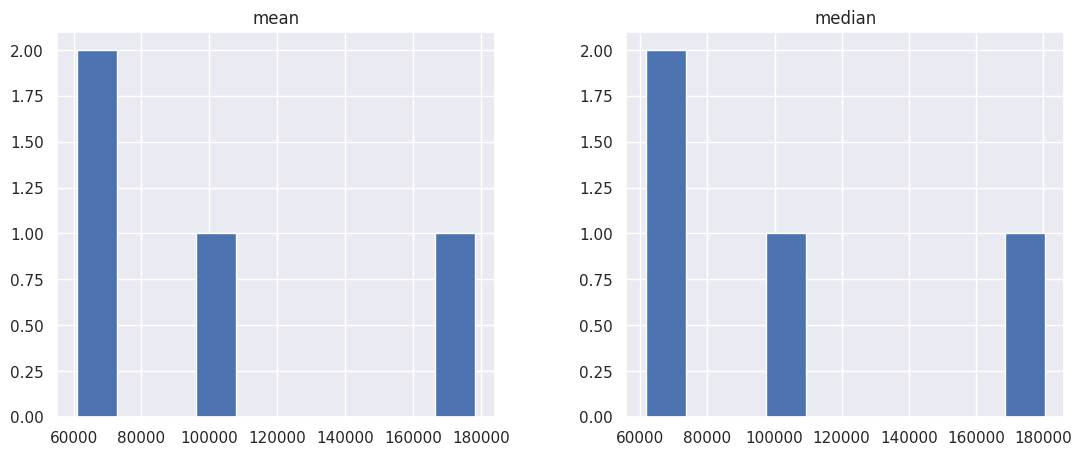

In [107]:
df_result.hist()
plt.show()

Dado a proporção de NaN da feature **Salary** representar 25% dos dados da nossa base, iremos então substituir a nivel e experimento os dados NaN por um range entre a média e a mediana da feature **Education** que possui grau escolar **Bachelor**, afim de manter uma uniformidade e variabilidade entre os dados sem agregar viés.

In [108]:
#Filtrando dados
df_calc_na = df_filter.loc[df_filter['education'] == 'Bachelor']

#calculando as medidas
mean_salary = df_calc_na['salary'].mean()
median_salary = df_calc_na['salary'].median()

#calculando a quantidade de NAN
total_na = df2['salary'].isna().sum()

#definindo limites minimos e maximos
lower_limit = min(mean_salary, median_salary)
upper_limit = max(mean_salary, median_salary)

#Gerando os valores dentro do range de NA com base nos limites
fill_values = np.random.uniform(lower_limit, upper_limit, size = total_na)

#Prenchendo os valores
df2.loc[df2['salary'].isna(), 'salary'] = fill_values

## 2.6 - OUTLIERS VOLUMETRY

In [115]:
outliers_volumetry(df2)

,attributes,quantity,percentual
0,loyalty_number,0,0.0
1,year,0,0.0
2,month,0,0.0
3,flights_booked,528,0.1
4,flights_with_companions,71560,17.6
5,total_flights,1984,0.5
6,distance,146,0.0
7,points_accumulated,127,0.0
8,points_redeemed,24181,6.0
9,dollar_cost_points_redeemed,24181,6.0
